## Dataset

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [26]:
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [27]:
print("nums of train:", len(train_data))
print("nums of test:", len(test_data))

nums of train: 60000
nums of test: 10000


In [28]:
image, label = train_data[0]
print("Shape of img:", image.shape)  # örn: torch.Size([1, 32, 32])
print("Label:", label)
print("Type:", type(image))

Shape of img: torch.Size([1, 32, 32])
Label: 5
Type: <class 'torch.Tensor'>


In [29]:
image

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

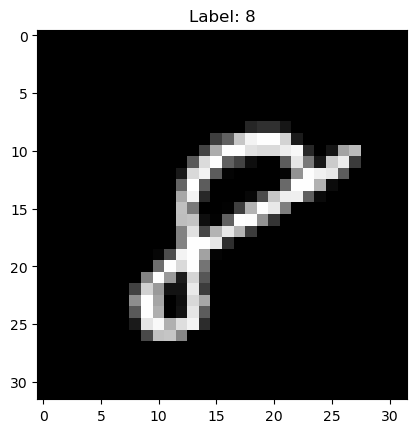

In [30]:
import matplotlib.pyplot as plt

image, label = train_data[59999]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Model 2

In [31]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNv2(nn.Module):
    def __init__(self):
        super(CNNv2, self).__init__()

        # Evrişimli Katman 1: Girdi = 1x32x32, Çıktı = 16x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Evrişimli Katman 2: Çıktı = 32x10x10
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Tam bağlantılı katmanlar
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)
        self.dropout1 = nn.Dropout(p=0.5)  # %50 ihtimalle düğümleri sıfırlar
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x


## Model Train on Train Dataset

In [40]:
import torch
import torch.optim as optim
model = CNNv2()

In [41]:
for name, param in model.named_parameters():
    print(f"Parametre adı: {name}")
    print(f"Şekli: {param.shape}")
    print(f"Değerler:\n{param}")
    print("-----------")

Parametre adı: conv1.weight
Şekli: torch.Size([16, 1, 5, 5])
Değerler:
Parameter containing:
tensor([[[[-0.0995,  0.1842,  0.1483, -0.1682, -0.1315],
          [ 0.0845,  0.1097,  0.1544,  0.0647, -0.0203],
          [ 0.1629, -0.1171,  0.1996, -0.0731,  0.1977],
          [-0.0558, -0.1307,  0.0508,  0.1288,  0.1006],
          [-0.0115, -0.1787, -0.1003, -0.1488,  0.1472]]],


        [[[-0.0795,  0.0302,  0.1814, -0.1558,  0.0800],
          [-0.0418,  0.0433,  0.0714, -0.1596, -0.1694],
          [-0.0331,  0.1527, -0.1157, -0.1649,  0.1255],
          [-0.1262,  0.1770,  0.1187,  0.1416, -0.0188],
          [-0.1505,  0.0971, -0.1644, -0.0352, -0.1473]]],


        [[[ 0.0663,  0.0361, -0.0957,  0.0407,  0.1841],
          [-0.0637,  0.0369, -0.0946,  0.0407, -0.1884],
          [ 0.0616, -0.0453,  0.1748, -0.0033,  0.1667],
          [-0.0985,  0.0293,  0.0249,  0.0010, -0.0950],
          [ 0.0597, -0.1585, -0.0943, -0.1904,  0.0598]]],


        [[[ 0.0040, -0.0611,  0.0361, -0

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(2): 
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.5164
Epoch 2, Loss: 0.2835


## Model Test on Test Dataset

In [43]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.58%


In [44]:
correct

9858